# CNN (Exercise 11-1)
Exercise Sung Kim lesson 11: Advanced CNN<br>
https://arxiv.org/abs/1602.07261<br>
Test with CIFAR-10<br>

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

device = 'cpu'

In [16]:
print('==> Preparing data..')
transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [17]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    y_test = []
    y_pred = []
    with torch.no_grad():
        for data, target in test_loader:
#             import ipdb; ipdb.set_trace()
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            y_test += list(target)
            y_pred += list(pred.view_as(target))
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # Confusion matrix
    confusion_mtx = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion_mtx, classes=classes, normalize=True,
                          title='Normalized confusion matrix')


# 1. Model

In [68]:
class Net1(torch.nn.Module):
    """
    Normal CNN 62% accuracy
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 100, kernel_size=5, stride=1) # in_channel is 1. Because it has 1 color
        self.conv2 = nn.Conv2d(100, 80, kernel_size=5, stride=1)
        
        self.mp = nn.MaxPool2d(2)
        self.linear1 = nn.Linear(2000, 200)
        self.fc = nn.Linear(200, 10)

    def forward(self, x):
        in_size = x.size(0)
        
        x = F.relu(self.mp(self.conv1(x)))
        x = F.relu(self.mp(self.conv2(x)))
        
        x = x.view(in_size, -1) # flatten the tensor
        x = F.relu(self.linear1(x))
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

class SimpleCCN(nn.Module):
    def __init__(self):
        

In [69]:
model = Net1()

# 2. Loss & Optimizer
criterion has been absorbed to the `train and test` functions already

In [70]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.307091
Train Epoch: 1 [10000/50000 (20%)]	Loss: 1.334784
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.301145
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.327301
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.358088

Test set: Average loss: 1.1426, Accuracy: 5976/10000 (60%)

[[664  20  61  25  21   2  20   5 156  26]
 [ 42 645  17  21   2   1  25   1  96 150]
 [ 71   9 582 100  57  50  79  17  23  12]
 [ 22   8 131 492  64  93 129  15  18  28]
 [ 35  12 233  79 407  19 124  56  28   7]
 [ 19   5 138 336  60 329  55  36  10  12]
 [  9   4  94  56  25   8 777   8  11   8]
 [ 32   1  65  92  86  54  24 585  11  50]
 [ 74  28  17  27   4  11  11   3 786  39]
 [ 49 108  14  28   5   2  16   4  65 709]]


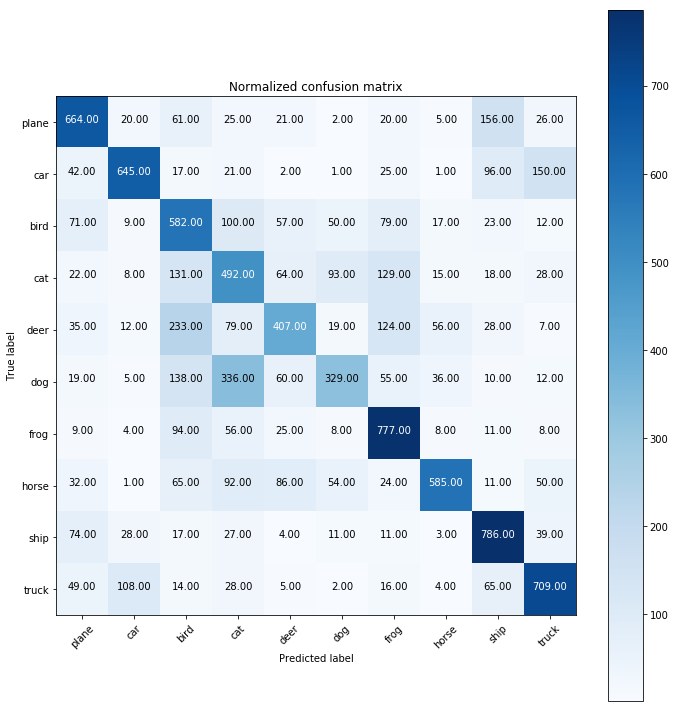

In [71]:
for epoch in range(1, 1 + 1):
    train(model, 'cpu', trainloader, optimizer, epoch)
    test(model, 'cpu', testloader)

# Scratch Note

In [13]:
target = torch.tensor([3, 2 ,2, 4], dtype=torch.long)
pred = torch.tensor([8,2,2,4], dtype=torch.long)

In [14]:
y_test = list(target)
y_pred = list(pred)

[[2 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 0 0]]


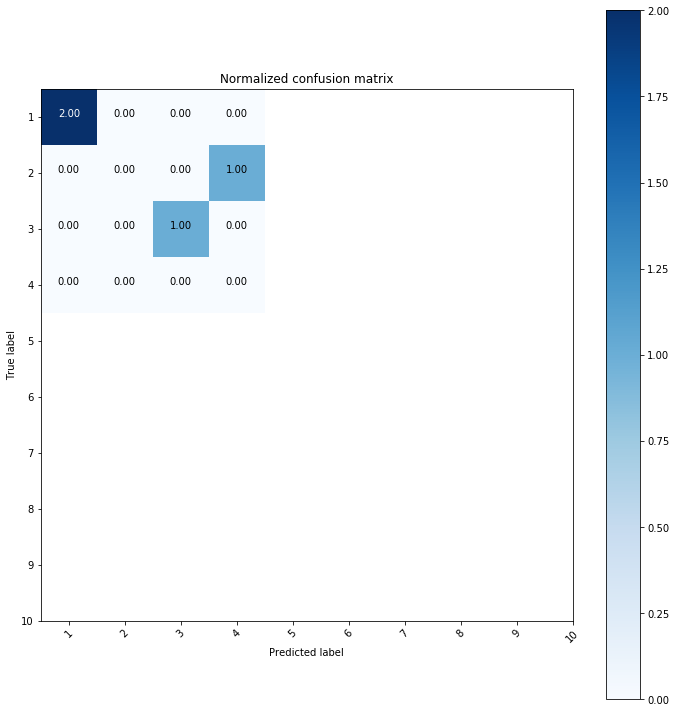

In [15]:
confusion_mtx = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion_mtx, classes=[i for i in range(1, 10 + 1)], normalize=True,
                      title='Normalized confusion matrix')
